<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Spectral Analysis with Pyleoclim

## Authors

Deborah Khider

Author1 = {"name": "Deborah Khider", "affiliation": "Information Sciences Institute, University of Southern California", "email": "khider@usc.edu", "orcid": "0000-0001-7501-8430"}

## Preamble

### Goals

- Understand the various methods for spectral analysis accessible through Pyleoclim
- Understand the effect of pre-processing on spectral analysis
- Determine significance of spectral power

**Reading time:**

### Keywords

Spectral Analysis

### Pre-requisites

Pre-processing method available through Pyleoclim. An understanding of spectral analysis is a must. 

### Relevant Packages

None

## Data Description

This tutorial makes use of the following dataset, stored in CSV format: 

* Lisiecki, L. E., and Raymo, M. E. (2005), A Pliocene-Pleistocene stack of 57 globally distributed benthic δ18O records, Paleoceanography, 20, PA1003, [doi:10.1029/2004PA001071](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071).


## Demonstration

Let's import the necessary packages:

In [1]:
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first import the data into a Pandas DataFrame from which we can create our [`Series` object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#series-pyleoclim-series):

In [2]:
df = pd.read_csv('../data/LR04.csv',skiprows=4)
df.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


In [3]:
lr04 = pyleo.Series(time=df.iloc[:,0],value=df.iloc[:,1],value_name='Benthic $\delta^{18}O$',value_unit=u'\u2030',
                   time_name='Age',time_unit='ky BP',label='LR04')

Let's plot this iconic compilation:

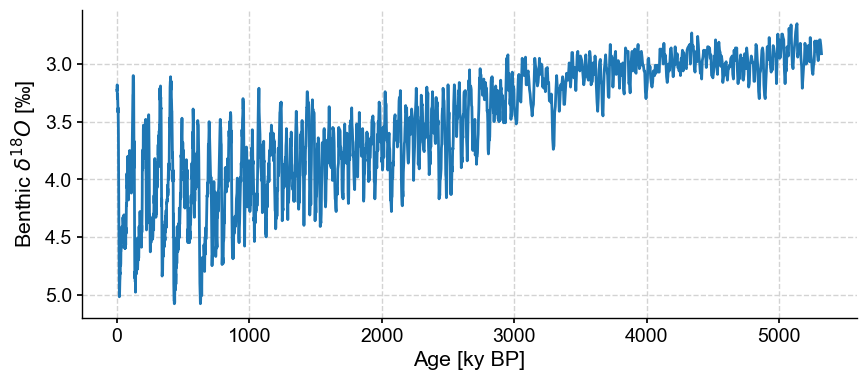

In [4]:
fig, ax = lr04.plot(legend=False) 
ax.invert_yaxis()

Let's work with the first 3 million years (3000 kyr) of the record for illustrative purposes:

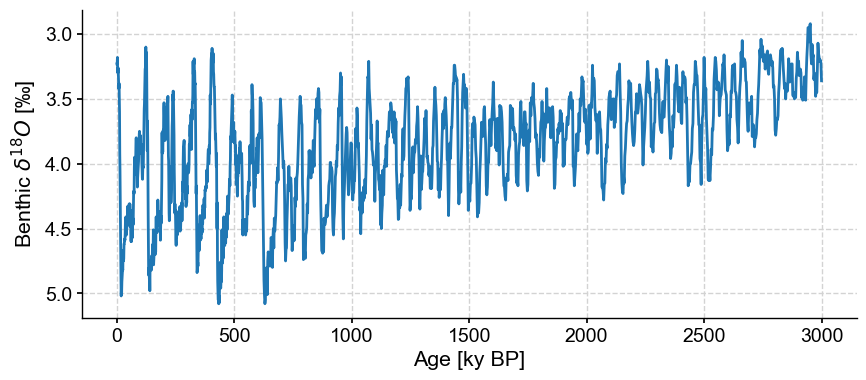

In [5]:
lr04_s = lr04.slice([0,3000])
fig,ax = lr04_s.plot(legend=False) 
ax.invert_yaxis()

### Spectral methods

Pyleoclim enables five spectral analysis methods:
* **Basic Periodogram**, which uses a Fourier transform. The method has various windowing available to reduce variance. 
* **Welch's periodogram**, a variant of the basic periodogram, which uses Welch's method of overlapping segments. The periodogram is computed on each segment and averaged together
* **Multi-taper method (MTM)**, which attempts to reduce the variance of spectral estimates by using a small set of tapers rather than the unique data taper or spectral window
* **Lomb-Scargle periodogram**, an inverse approach designed for unevenly-spaced datasets. Several windows are available and Welch's segmentation can also be used with this method. 
* **Weighted wavelet Z-transform**, a wavelet-based method also made for unevenly-spaced datasets.

All of these methods are available through [`Series.spectral`](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.spectral) by changing the method argument. Let's have a look at the various methods. Since the first three methods require evenly-spaced data, we will be using a simple linear interpolation. The effect of pre-processing on the periodogram is discussed further in this notebook.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

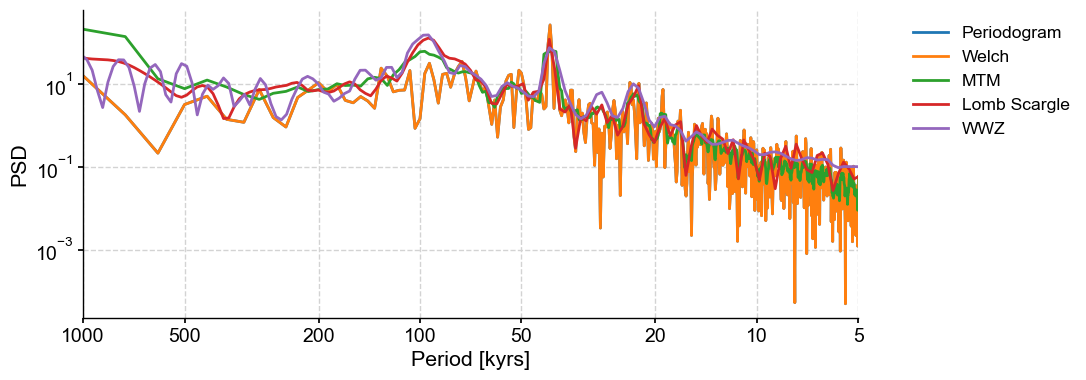

In [6]:
PSD_p = lr04_s.standardize().interp().spectral(method='periodogram')
fig, ax = PSD_p.plot(label = 'Periodogram')
lr04_s.standardize().interp().spectral(method='welch').plot(ax=ax,label='Welch')
lr04_s.standardize().interp().spectral(method='mtm').plot(ax=ax,label='MTM')
lr04_s.standardize().spectral(method='lomb_scargle').plot(ax=ax,label='Lomb Scargle')
lr04_s.standardize().spectral(method='wwz').plot(ax=ax,label='WWZ',lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

These methods return similar answers, with peaks in the orbital bands at around ~23kyr, 40kyr, and (except for the Periodogram and Welch methods) 100kyr. This is not surprising given that the benthic stack is orbitally tuned. We would expect these periodicities to show up. The fact that the Periodogram and Welch methods miss the 100-kyr cycle is interesting. 

But let's have a look at the various arguments for the functions and let's run down some of the important ones. In Pyleoclim, each of the method parameters should be passed through the argument `settings`, which takes a dictionary of possible key/value that corresponds to the argument of the underlying function. Look at the `See also` section in the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.spectral). From there, you can have a look at the parameters for the specific methods. 

<div class="alert alert-warning">
Pyleoclim gives you great power when it comes to data analysis but your responsibility is to understand how to appropriately set the parameters and choose the method that is most appropriate for your study.
</div>

#### Periodogram

The most important parameter here is `window` which corresponds to the type of window to be used to reduce the variance. If you are interested in seeing the impact of these windows on a spectrum, look at this [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window). The `detrend`, `gaussianize`, and `standardize` parameters correspond to pre-processing steps that can either be passed directly to the function or with method cascading. I prefer using the dedicated functions rather than the parameters as it makes it easier to follow the order in which these operations occurred. 

For the purpose of this tutorial, let's consider the following windows: `boxcar`, `bartlett`, and `blackmanharris` (note that the default window is `hann`):

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

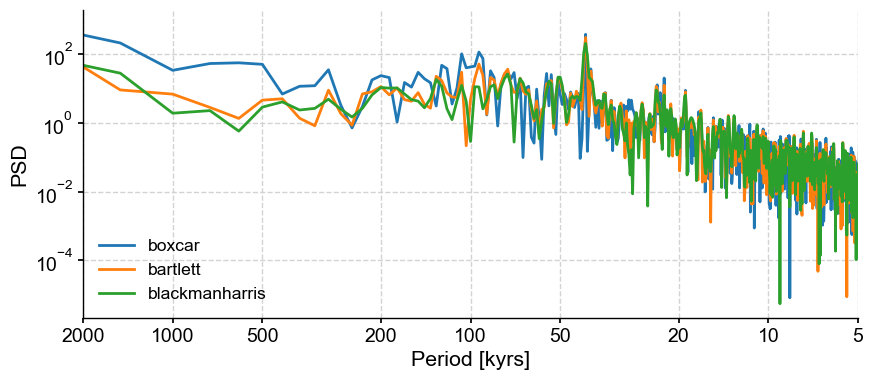

In [7]:
PSD_boxcar = lr04_s.standardize().interp().spectral(method='periodogram', settings={'window':'boxcar'})
fig,ax = PSD_boxcar.plot(label = 'boxcar')
lr04_s.standardize().interp().spectral(method='periodogram', settings={'window':'bartlett'}).plot(ax=ax,label='bartlett')
lr04_s.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'}).plot(ax=ax,label='blackmanharris')

The periodograms look very similar, except for that 100-kyr band, which could be interpreted as present (albeit maybe not significant) when using a boxcar window. This example highlights the danger of over-interpreting peaks in spectral analysis.

#### Welch

Welch's method divides the series into segments to obtain a more stable estimate of the periodogram. Besides `window`, the two relevant parameters are `nperseg` and `noverlap`, which corresponds to the number of points and fraction of overlap (in %). The default will give you three segments with 50% overlap. Let's look at 4,5,6 segments with 50% overlap:

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

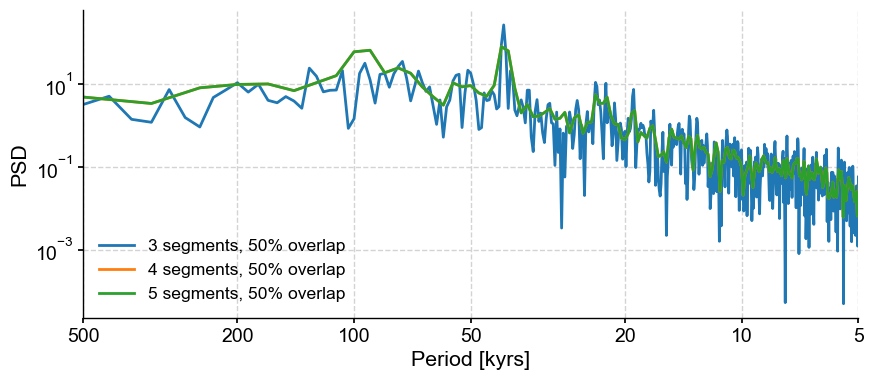

In [8]:
PSD_welch = lr04_s.standardize().interp().spectral(method='welch')
fig,ax = PSD_welch.plot(label='3 segments, 50% overlap')
lr04_s.standardize().interp().spectral(method='welch', settings = {'nperseg':len(lr04_s.value)/3}).plot(ax=ax,label='4 segments, 50% overlap')
lr04_s.standardize().interp().spectral(method='welch', settings = {'nperseg':len(lr04_s.value)/3}).plot(ax=ax,label='5 segments, 50% overlap')

This, again, cautions against overinterpreting the 100-kyr peak in the data.

#### MTM

The most important parameter for MTM is the time-bandwidth product `NW`, which controls the amount of leakage out of a given spectral line ([see. Ghil et al, 2002](https://doi.org/10.1029/2000RG000092)). This parameter is usually set between 2 and 4 (which is the default for Pyleoclim) in increments of 1/2. 4 is the most conservative choice advocated by MTM's originator (D. Thomson), though the code allows you to go higher (and therefore, smoother) if you think that is warranted:

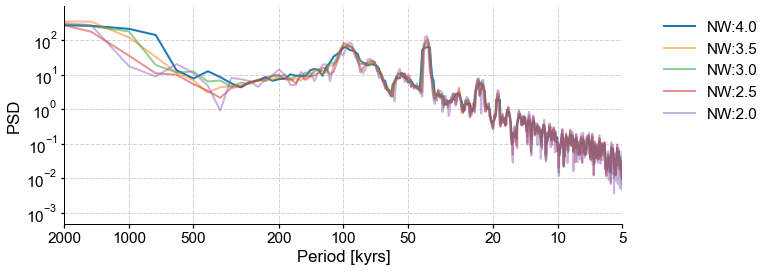

In [9]:
PSD_nw4 = lr04_s.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'NW:4.0')
for item in np.flip(np.arange(2,4,0.5)):
    lr04_s.standardize().interp().spectral(method='mtm', settings={'NW':item}).plot(ax=ax, label = 'NW:'+str(item), alpha=0.5, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

Let's have a look at the effect of NW on the periodogram. As NW decreases, the peaks become sharper. This is particularly apparent in the 2000 kyr band (which corresponds to the trend in data; as we will see shortly), whereas the peak corresponding to $NW=4$ is much broader. The tradeoff (there is always one in spectral analysis) is that the variance is higher for smaller values of NW (it cannot be seen on this plot, but it means that there is more uncertainty as to the height of a narrow peak than a diffuse one). 

#### Lomb-Scargle

The [Lomb-Scargle periodogram](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.spectral.lomb_scargle) is meant to work with unevenly-spaced timeseries. The parameters of importance here are:
* The frequency vector, which can either be user-specified or calculated using different methods ('log','lomb_scargle','welch', 'scale', and 'nfft'), which determines at which points in the frequency domain the periodogram should be computed. This a trade-off: if using too many points, some peaks might be spurious. Not enough and you can miss some sifnigicant periodicities. There is also a computational trade-off here: the more points, the longer it takes for the code to run.
* n50: which determines the number of overlapping segments with 50% overlap using the Welch method
* window, as we have seen for the periodogram.

**Note:** The `Series.spectral` method overwrites the default 'lomb-scargle' method for this function and uses 'log' as its frequency method.

Let's take a look at the effect of these parameters one by one. Also notice that the data need no interpolation with this method.

##### Frequency vector

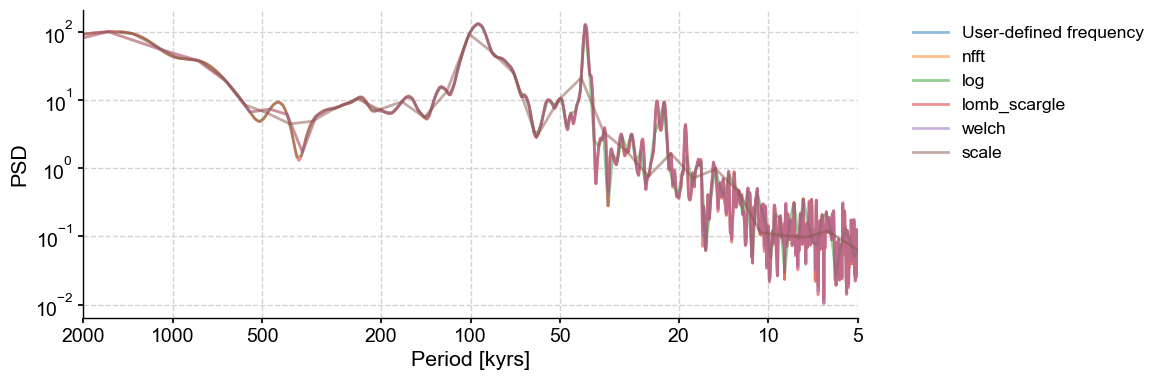

In [9]:
freq = np.arange(1/2000,1/5,1/10) # a user defined one to get started. This one should be passed through settings

PSD_ls = lr04_s.standardize().spectral(method='lomb_scargle', settings={'freq':freq})
fig,ax = PSD_ls.plot(label = 'User-defined frequency',alpha=0.5)

freq_methods = ['nfft','log','lomb_scargle','welch', 'scale']
for freq_method in freq_methods:
    lr04_s.standardize().spectral(method='lomb_scargle', freq_method=freq_method).plot(ax=ax,label=freq_method,alpha=0.5, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

Note how the 40-kyr peak is pooly defined using the frequency vector from the `scale` method.

##### n50

Let's look at the effect of segmentation. The default is to use 3 segments with 50% overlap. 

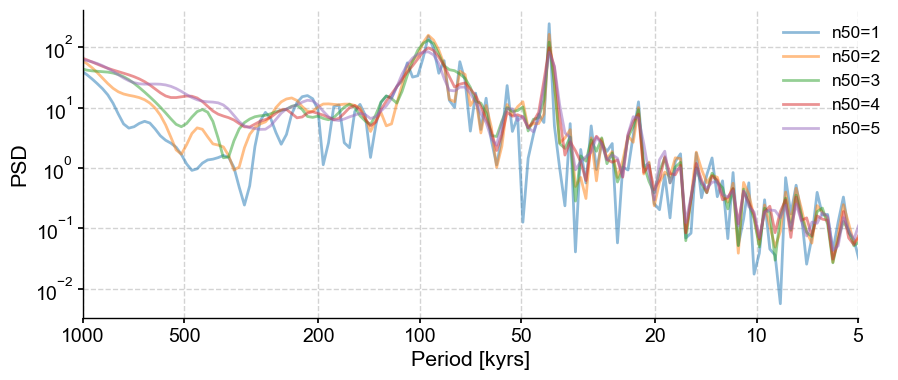

In [10]:
PSD_ls = lr04_s.standardize().spectral(method='lomb_scargle', settings={'n50':1})
fig,ax = PSD_ls.plot(label = 'n50=1',alpha=0.5)

n50s = np.arange(2,6,1)
for item in n50s:
    lr04_s.standardize().spectral(method='lomb_scargle', settings={'n50':item}).plot(ax=ax,label='n50='+str(item),alpha=0.5, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

By design, Welch's method shows less variance (smoother spectra) with a greater number of segments. The trade-off here is since the spectrum is estimated on a smaller portion of the timeseries, low-frequency cycles (if any) can be lost in the segments. If the interest is in low-frequency cyclicities that may only repeat 3-4 times, then n50 should be set as low as possible.

##### window

Let's examine the behavior with the windows we selected above: `boxcar`, `bartlett`, and `blackmanharris`. Note that Lomb-Scargle is the default method in Pyleoclim, so we will not set that argument in the example.

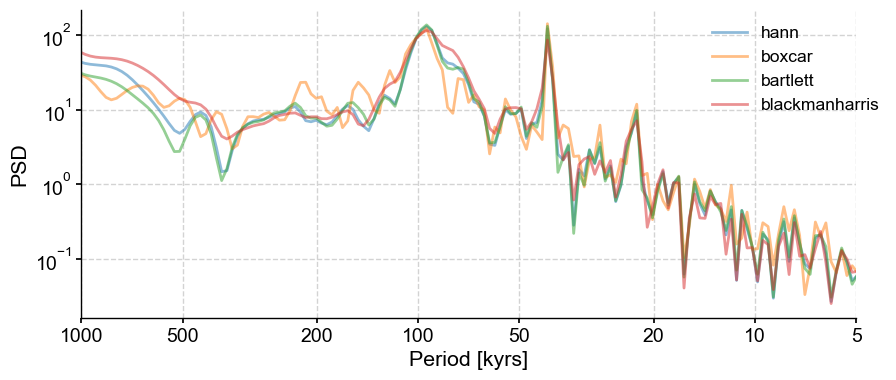

In [11]:
window =  ['boxcar', 'bartlett', 'blackmanharris']

PSD_ls = lr04_s.standardize().spectral()
fig,ax = PSD_ls.plot(label = 'hann',alpha=0.5)

for item in window:
    lr04_s.standardize().spectral(settings={'window':item}).plot(ax=ax,alpha=0.5,label = item, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

The choice of window is not as critical as with the basic Fourier periodogram.

<div class="alert alert-warning">
The Lomb-Scargle periodogram seems like the best choice for most applications: (1) it seems to give consistent results over parameter ranges, (2) doesn't require interpolation, limiting timeseries manipulation, and (3) it fairly fast to compute. This is the reason why it is the default method in Pyleoclim. <bf>However,</bf> the serious drawback of the Lomb-Scargle periodogram is that the power is biased towards high frequencies, making spectral slope calculations inaccurate. If you're interested in computing spectral slopes (see <a href="https://github.com/LinkedEarth/PyleoclimPaper/blob/main/MD%20Confrontation/Model-data%20confrontation.ipynb"> this notebook for a study </a>), this is  <bf>NOT</bf> the method to use. 
</div>

#### WWZ

The weighted wavelet Z transform is a wavelet method from which the spectral density can be computed. You have two options to go about it: (1) calculate the scalogram separately and then compute the periodogram via time integration or (2) use the method through the `spectral()` method of the _Series_ class. 

Let's try both and compare:

##### Method 1: Compute PSD through a scalogram

The first step is to use the wavelet function to calculate the scalogram. The second is to pass the computed scalogram to the `scalogram` parameter in the spectral function:

In [12]:
scal = lr04_s.standardize().wavelet(method='wwz')
psd_wwz = lr04_s.standardize().spectral(method='wwz',scalogram=scal)

##### Method 2: Using the spectral method

In [14]:
psd_wwz_d = lr04_s.standardize().spectral(method='wwz')

Now let's plot them and compare:

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

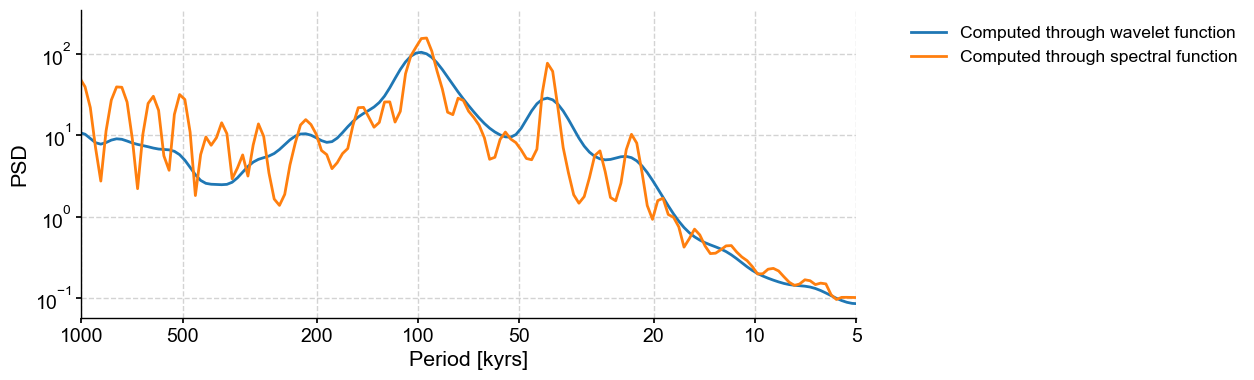

In [15]:
fig,ax = psd_wwz.plot(label='Computed through wavelet function')
psd_wwz_d.plot(ax=ax, label='Computed through spectral function', lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

Big difference!!! So what's happening here? Let's have a look at the various implementations:
* [Spectral wwz](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.spectral.wwz_psd)
* [Wavelet wwz](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#module-pyleoclim.utils.wavelet.wwz)

Both of them take a parameter called `c`, which corresponds to the wavelet's decay constant. This constant balances the time resolution and frequency resolution of the wavelet analysis. The smaller this constant is, the sharper the peaks. For spectral analysis, where the purpose is to find peaks, a smaller value for `c` is needed compared to wavelet analysis, where time-frequency localization is of the essence. If you look at the defaults for these two functions, `c` takes on different values for each of the cases. 

So why did we enable the passing of scalograms if they're not appropriate to use? The short answer is time. It may not have felt this way here but the WWZ algorithm is considerably slower than the other spectral methods. When computing one periodogram, this is not an issue. However, for significance testing, this can be rather time consuming. Therefore, passing the scalograms can be sufficient for preliminary data exploration. 


### Determining significance

Great, we've found peaks. Now it's time to determine whether said peaks are significant. That is: do they stand out compared to what might expect to see in a random timeseries? Pyleoclim tests against an AR(1) benchmark, simulating surrogates of the time series. Let's use this on the Lomb-Scargle method and test against 90%, 95%, and 99% significance level through the [`PSD.signif_test`](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.psds.PSD.signif_test). The `qs` parameter is adjusted for the desired significance levels. 

Performing spectral analysis on individual series: 100%|██████████████████████████████████| 200/200 [00:01<00:00, 117.65it/s]


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

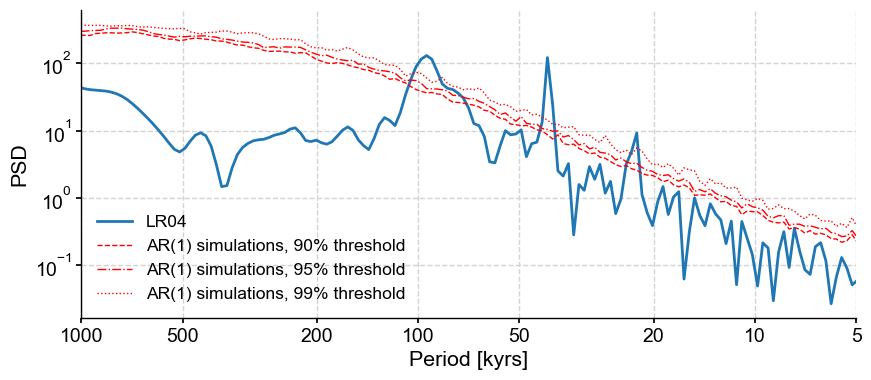

In [16]:
lr04_s.standardize().spectral().signif_test(qs=[0.90,0.95,0.99]).plot()

According to the significance testing, the peaks corresponding to orbital cylicities are significant in the data. I would still interpret the 100-kyr peak with caution since other methods cannot identify it. 

What other parameters are available? One is `number` which sets the number of surrogates to generate. Notice how the 99% threshold is not smooth. This is due to the fact that we are looking for the 99% quantile in only 200 surrogates ($n=2$). Let's increase that number to 1000:

Performing spectral analysis on individual series: 100%|████████████████████████████████| 1000/1000 [00:08<00:00, 115.61it/s]


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

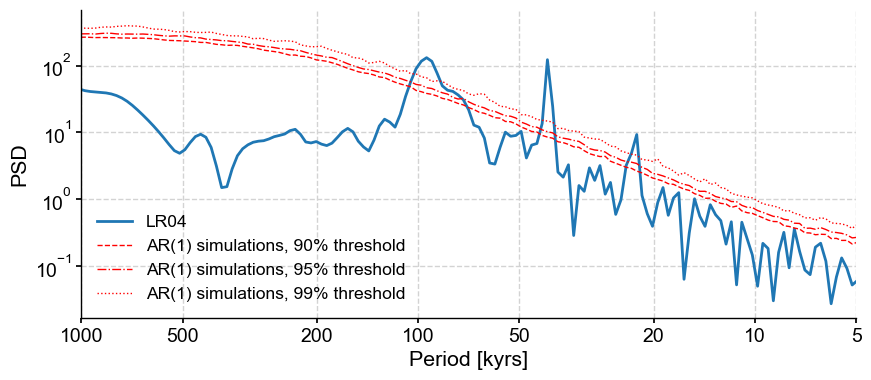

In [17]:
lr04_s.standardize().spectral().signif_test(number=1000, qs=[0.90,0.95,0.99]).plot()

This took about 5 times longer (yes, the problem scales linearly). But a 20s wait is not bad considering how much smoother the threshold look. And what is 20s compared to months of a paper lingering in peer-review limbo?

You might ask, if it's only 20s, why is the default 200? Because the WWZ method takes significantly more time. Let's try it:

Performing spectral analysis on individual series: 100%|█████████████████████████████████████| 10/10 [01:05<00:00,  6.51s/it]


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

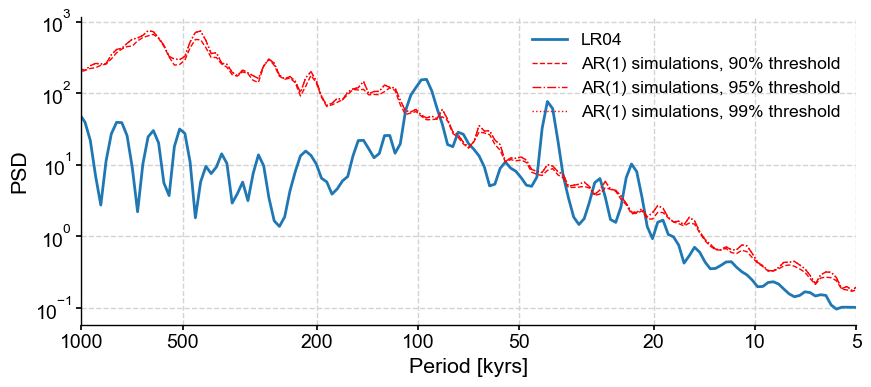

In [18]:
lr04_s.standardize().spectral(method='wwz').signif_test(number=10, qs=[0.90,0.95,0.99]).plot()

Running the analysis over 10 surrogates took about 1 minute. Therefore, 200 would take about 20 minutes and 1000 would take 1hr40min to run. 10 surrogates is not enough to make a determination about significance (so don't take this figure too seriously) but 20min is good compromise between computation time and science interpretation. 

### Effect of pre-processing on spectral analysis

Oftentimes, the timeseries need the following pre-processing step:
* **standardization**: this is a must for most of our techniques here
* **even sampling**, which is needed for methods that do not take unevenly-spaced data natively (MTM, Periodogram, and Welch). Pyleoclim offers several imputation schemes and we will look at the impact here
* **detrending**.

#### Effect of detrending

The LR04 curve has a trend over the past 3 million years, which corresponds to increased ice volume from long-term cooling of the Earth and growth of polar ice caps, which enrich the oceans in the heavy oxygen isotope. Let's remove the trend:

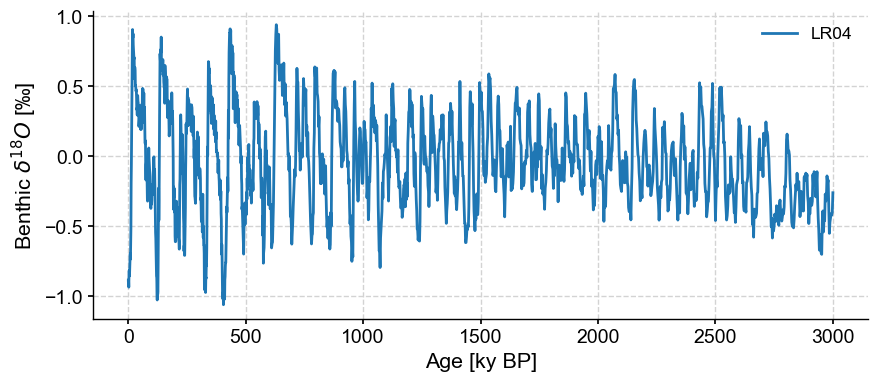

In [19]:
ts = lr04_s.detrend().plot()

Let's compare the two periodograms using the Lomb-Scargle method:

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

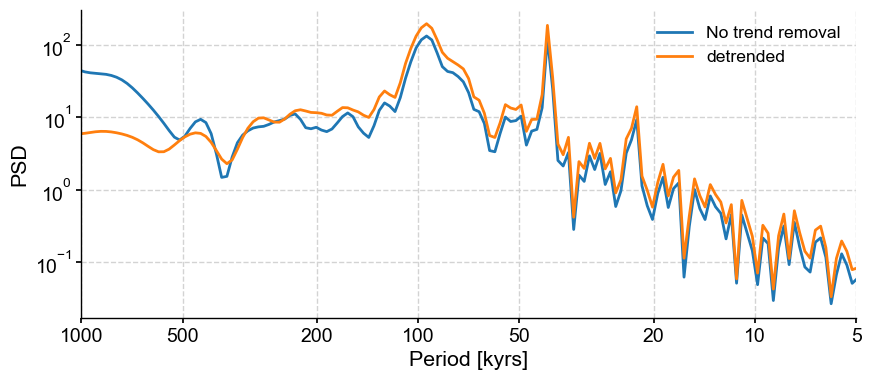

In [20]:
fig,ax = lr04_s.standardize().spectral().plot(label = 'No trend removal')
lr04_s.detrend().standardize().spectral().plot(ax=ax,label='detrended')

In this case, the detrending doens't seem to matter much in the interpretation of our results.

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

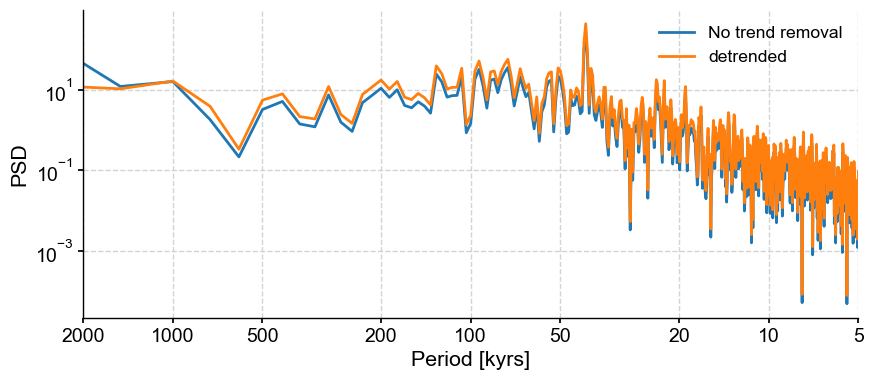

In [21]:
fig,ax = lr04_s.interp().standardize().spectral(method='periodogram').plot(label = 'No trend removal')
lr04_s.detrend().interp().standardize().spectral(method='periodogram').plot(ax=ax,label='detrended')

For more details on detrending, see _filtering_and_detrending.ipynb_

#### Effect of imputation

For the spectral methods requiring unevenly-spaced data (such as MTM), imputation is needed. Let's run through various methods:

* linear interpolation
* spline interpolation
* binning
* Gaussian kernel

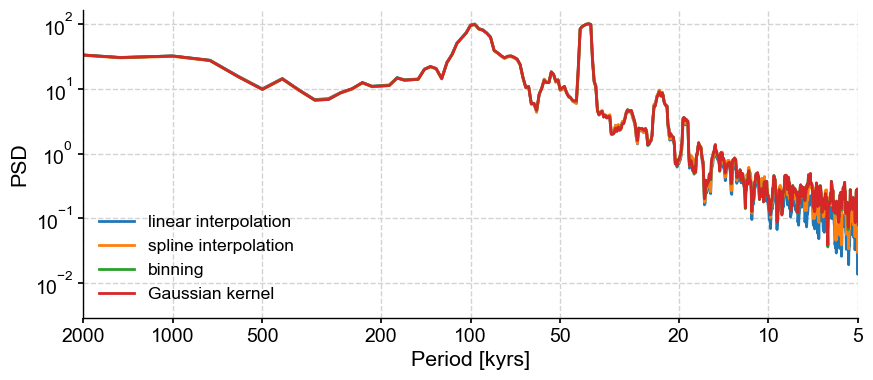

In [22]:
method = ['linear interpolation', 'spline interpolation', 'binning', 'Gaussian kernel']

fig, ax = plt.subplots(figsize=[10,4])

for item in method:
    if item == 'linear interpolation':
        lr04_s.detrend().interp().standardize().spectral(method='mtm').plot(ax=ax,label=item)
    elif item == 'spline interpolation':
        lr04_s.detrend().interp(method='cubic').standardize().spectral(method='mtm').plot(ax=ax,label=item)
    elif item == 'binning':
        lr04_s.detrend().bin().standardize().spectral(method='mtm').plot(ax=ax,label=item)
    elif item == 'Gaussian kernel':
        lr04_s.detrend().gkernel().standardize().spectral(method='mtm').plot(ax=ax,label=item)
        

The type of imputation doesn't matter for this application. However, we have used the default parameters for each of these techniques for the `step` size, which refers to the interpolation step. The default is the mean time increment, but it can be adjusted to taste:

<AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>

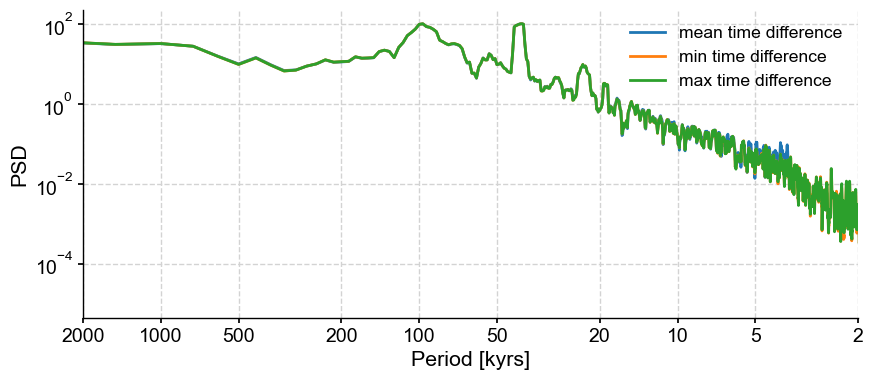

In [23]:
max_step = np.abs(np.max(np.diff(lr04_s.value))) # maximum spacing between two time points
min_step = np.abs(np.min(np.diff(lr04_s.value))) # minimum spacing between two time points

fig,ax = lr04_s.detrend().interp().standardize().spectral(method='mtm').plot(label='mean time difference')
lr04_s.detrend().interp(step=min_step).standardize().spectral(method='mtm').plot(ax=ax, label='min time difference')
lr04_s.detrend().interp(step=max_step).standardize().spectral(method='mtm').plot(ax=ax, label='max time difference')

For this series, the pre-processing doesn't induce changes in the periodograms (this is GREAT news: the results are robust). Based on the work so far, the 23-kry and 40-kyr periodicities are robust features of the timeseries. The picture is less clear for the 100ky cycle, which appears clearly with some methods/parameter choices but not others. Our job is not to adjudicate this question, however...